In [1]:
import pandas as pd
import numpy as np
import json 

## Data Cleaning

In [2]:
df_articles = pd.read_csv('wikipedia_articles_cleaned.csv')

article_TitleID_dict = dict(zip(df_articles["article"], df_articles["pageid"]))

with open("article_TitleID_dict.json", "w") as f:
    json.dump(article_TitleID_dict, f, indent=4)

### Target Variables

In [3]:
from statistics import mean
import ast

wiki_quality = ["FA", "FL", "FM", "A", "GA", "B", "C", "Start", "Stub", "List"]

wiki_quality_cat_dict = {
    "FA":9, 
    "FL":8,
    "FM":7,
    "A":6, 
    "GA":5,
    "B":4,
    "C":3, 
    "Start":2,
    "Stub":1,
    "List":0,     
}

wiki_quality_aggcat_dict = {
    "FA":2, 
    "FL":2,
    "FM":2,
    "A":1, 
    "GA":1,
    "B":1,
    "C":1, 
    "Start":0,
    "Stub":0,
    "List":0, 
}

def parse_list(x):
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        return []  # fallback if parsing fails

def mean_list(class_list):
    mapped = [wiki_quality_cat_dict.get(c) for c in class_list if c in wiki_quality_cat_dict]
    return mean(mapped) if mapped else None

df_articles['all_quality_classes'] = df_articles['all_quality_classes'].apply(parse_list)

df_articles['QC_num'] = df_articles['all_quality_classes'].apply(mean_list)
df_articles['QC_aggcat'] = df_articles['quality_class'].map(wiki_quality_aggcat_dict)
df_articles['QC_cat'] = df_articles['quality_class'].map(wiki_quality_cat_dict)

### Ordinal Variables (needs order!)

In [4]:
from sklearn.preprocessing import LabelEncoder

mapping = {
    'unprotected': 0,
    'semi_protected': 1,
    'protected': 2,
    'fully_protected': 3,
}

le = LabelEncoder()
df_articles["encoded_protection_status"] = le.fit_transform(df_articles["protection_status"])

### Binary Variables (only works for 0/1)

In [5]:
df_articles['encoded_has_infobox'] = df_articles['has_infobox'].astype(int)

### Problem: (for high cardinality categorical variables)

In [6]:
import umap
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ast  # to safely evaluate strings
from sklearn.preprocessing import MultiLabelBinarizer
import umap

In [7]:
# Step 1: One-hot encode
ohe = OneHotEncoder(handle_unknown='ignore')
X_ohe = ohe.fit_transform(df_articles[['assessment_source']])

# Step 2: Reduce with UMAP
reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X_ohe)

# Optionally, add back to dataframe
df_articles['assessment_source_uma_1'] = X_umap[:, 0]
df_articles['assessment_source_uma_2'] = X_umap[:, 1]

/Users/ramius/.pyenv/versions/3.13.0/envs/py_venv_3.13.0/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


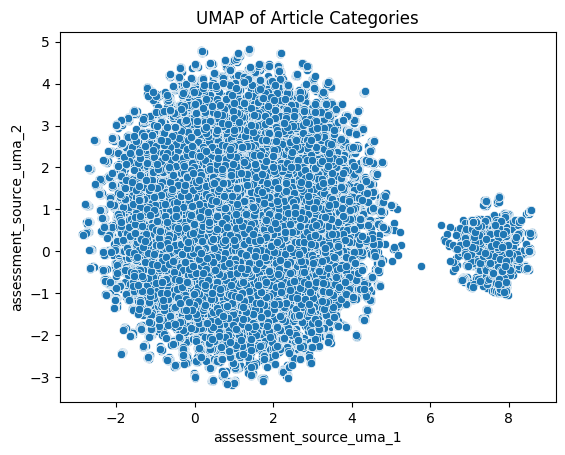

In [8]:
sns.scatterplot(x='assessment_source_uma_1', y='assessment_source_uma_2', data=df_articles)
plt.title("UMAP of Article Categories")
plt.show()

In [10]:
# Step 1: Convert string to list
df_articles['category_list'] = df_articles['categories'].apply(ast.literal_eval)

# Step 2: Multi-hot encode (like one-hot but for multiple values per row)
mlb = MultiLabelBinarizer(sparse_output=True)
X_multi_hot = mlb.fit_transform(df_articles['category_list'])

# Step 3: Dimensionality reduction
reducer = umap.UMAP(n_components=3)
X_umap = reducer.fit_transform(X_multi_hot)

# Step 4: Add reduced features back to DataFrame
df_articles['categories_umap_1'] = X_umap[:, 0]
df_articles['categories_umap_2'] = X_umap[:, 1]
df_articles['categories_umap_3'] = X_umap[:, 2]

/Users/ramius/.pyenv/versions/3.13.0/envs/py_venv_3.13.0/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Step 1: Convert string to list
df_articles['template_list'] = df_articles['templates'].apply(ast.literal_eval)

# Step 2: Multi-hot encode (like one-hot but for multiple values per row)
mlb = MultiLabelBinarizer(sparse_output=True)
X_multi_hot = mlb.fit_transform(df_articles['template_list'])

# Step 3: Dimensionality reduction
reducer = umap.UMAP(n_components=3)
X_umap = reducer.fit_transform(X_multi_hot)

# Step 4: Add reduced features back to DataFrame
df_articles['templates_umap_1'] = X_umap[:, 0]
df_articles['templates_umap_2'] = X_umap[:, 1]
df_articles['templates_umap_3'] = X_umap[:, 2]

/Users/ramius/.pyenv/versions/3.13.0/envs/py_venv_3.13.0/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


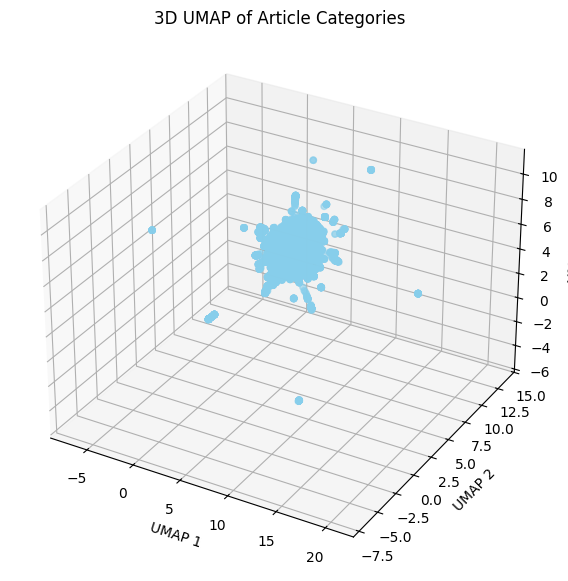

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    df_articles['templates_umap_1'],
    df_articles['templates_umap_2'],
    df_articles['templates_umap_3'],
    c='skyblue',  # or use another column for color, e.g., c=df_articles['QC_cat']
    s=20
)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
plt.title("3D UMAP of Article Categories")
plt.show()

***

In [ ]:
df_ArticleTargetFeatures = df_articles[["pageid",'QC_cat', 'QC_aggcat', 'QC_num', "num_categories", "num_links", "page_length", "num_references", "has_infobox", "num_sections", "num_templates", "protection_status", 'assessment_source']]

df_ArticleTargetFeatures.to_json("wikidata_ready4net.json", orient="records", indent=4)

***